In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb

    path_andrey = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    path_andrey = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Estimating T90 
    -importing the ASIM data (using Andrey data)
    -binning by 2 ms (or what is appropriate)
    -estimating background --> subtracting background from LC
    -Apply np.cumsum() on binned data and find % of observed counts

#### GRB 190606A
    -Seems like a good starting point; very short and bright!
    
    T90 estimation from different binsizes:
        - 1ms = 0.153999
        - 2ms = 0.154
        - 4ms = 0.152
        - 8ms = 0.152
        -16ms = 0.156
        
        
    Unrealiable background --> is overestimated resulting in negative counts
    Tried to clip the counts to 0, but then T90 is greatly overestimated again.
        -Tried with a quadratic fit, but error persists
        -Keeping to the negative counts, since this gives the "correct" result.
        
        
    Best approach seems to be linear fit from T0-0.75 to T0-0.25 with binsize=25ms, and using mean of cumsum of last 55 counts
    --> T90 = 0.24s
        

2019-06-06 01:55:06.781982


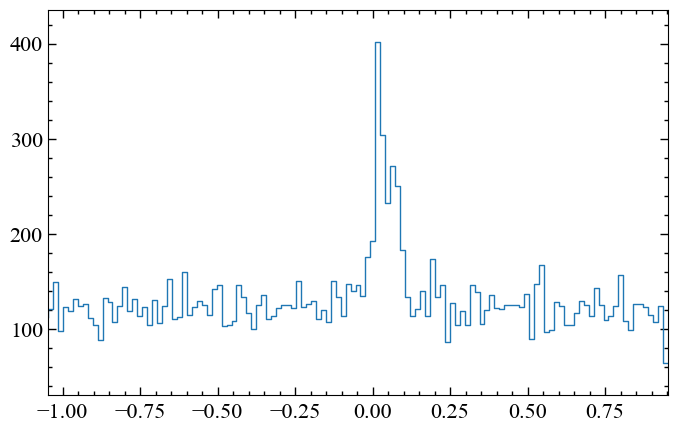

In [95]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

binsize = 0.016
tlagg_asim = -0.5366225269343781

# Load data
asimData = pd.read_csv(path_andrey+'GRB190606A.csv')
asimData['tus'] /= 1e6
asimData['tus'] += tlagg_asim
tus_asim = asimData['tus'].to_numpy()

# Calculate T0
T0 = datetime.fromisoformat('2019-06-06T01:55:07.318605') + timedelta(seconds=tlagg_asim)
print(T0)

# Create histogram
grb_190606A_hist = np.histogram(tus_asim, np.arange(tus_asim[0], tus_asim[-1] + binsize, binsize))
grb_190606A_counts, grb_190606A_edges = grb_190606A_hist[0], grb_190606A_hist[1]

plt.step(grb_190606A_edges[:-1],grb_190606A_counts)
plt.show()

1195.0596774193534
T90 = 0.2400000000000002 s


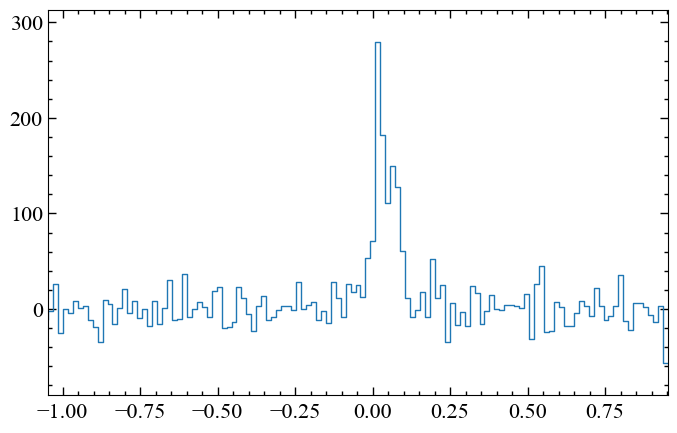

In [103]:
# Estimate background
ti_bkg, tf_bkg = -0.75, -0.25

# Select background range
background_range = (grb_190606A_edges[:-1] >= ti_bkg) & (grb_190606A_edges[:-1] < tf_bkg)

# Fit a quadratic polynomial to the counts in the background range
background_poly = np.polyfit(grb_190606A_edges[:-1][background_range], grb_190606A_counts[background_range], 1)

# Use the fitted polynomial to estimate the background level at all times
background_level = np.polyval(background_poly, grb_190606A_edges[:-1])

# Subtract background and ensure all counts are non-negative
background_subtracted = grb_190606A_counts - background_level


# Calculate cumulative sum
cumulative_counts = np.cumsum(background_subtracted)

# Calculate T90
total_counts = np.mean(cumulative_counts[-40:])
print(total_counts)
t1 = grb_190606A_edges[np.searchsorted(cumulative_counts, 0.05 * total_counts)]
t2 = grb_190606A_edges[np.searchsorted(cumulative_counts, 0.95 * total_counts)]
T90 = t2 - t1

print(f"T90 = {T90} s")

# Plot
plt.step(grb_190606A_edges[:-1], background_subtracted)
#plt.ylim(bottom=0)
plt.show()

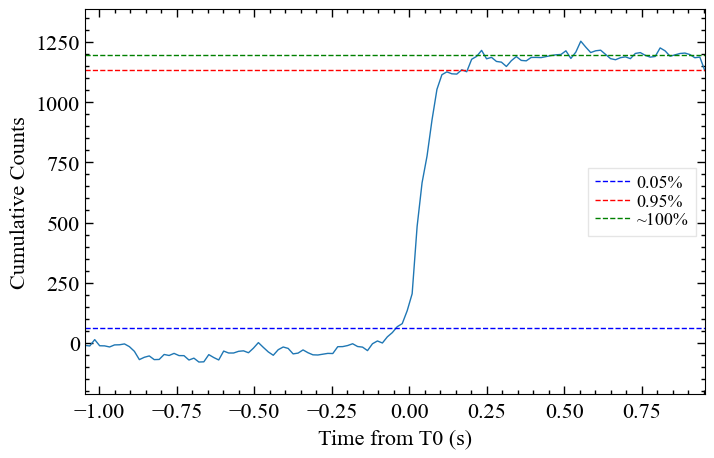

In [104]:
# Plot cumulative counts
plt.plot(grb_190606A_edges[:-1], cumulative_counts)
plt.xlabel('Time from T0 (s)')
plt.ylabel('Cumulative Counts')

# Add horizontal lines at 5% and 95% of total counts
plt.axhline(y=0.05 * total_counts, color='b', linestyle='--',label='0.05%')
plt.axhline(y=0.95 * total_counts, color='r', linestyle='--',label='0.95%')

# Add horizontal line at the average of the last 50 elements
plt.axhline(y=total_counts, color='g', linestyle='--',label='~100%')

plt.legend()
plt.show()

T0 2019-06-06 01:55:06.781982


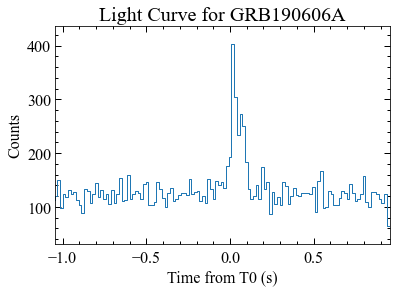

Mean background level: 122.0


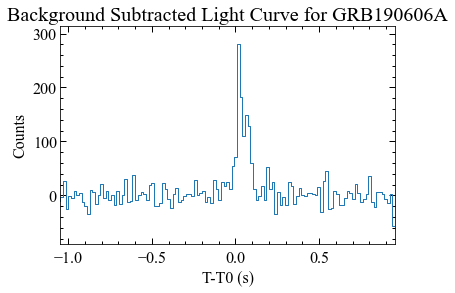

T90 for GRB190606A = 0.24 s
Mean total counts: 1195.0 estimated from T0 0.345 --> 0.969


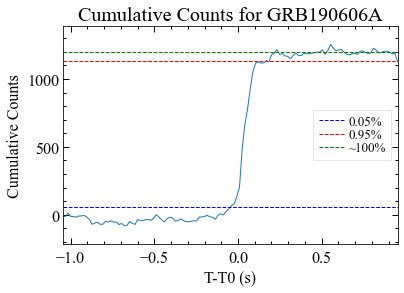

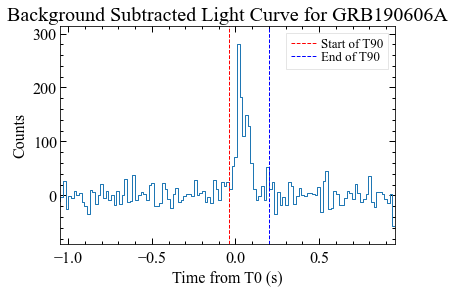

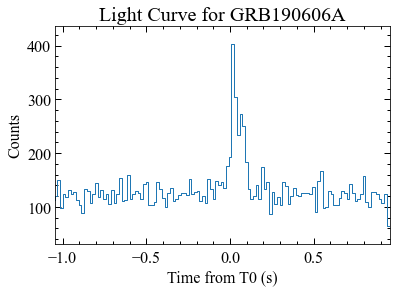

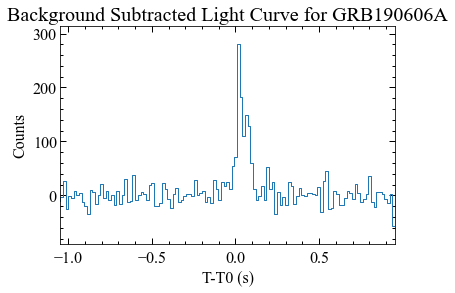

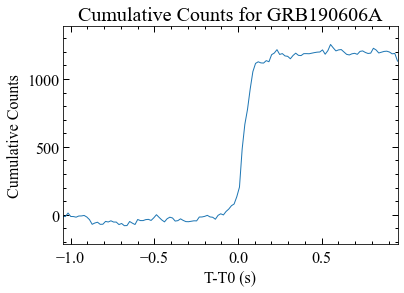

In [48]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def calculate_T90(GRB_id, binsize, tlagg_asim, T0, ti_bkg, tf_bkg, poly_degree=1, mean_index=-40):
    """
    Calculate the T90 duration of a given Gamma-Ray Burst (GRB).

    Parameters:
    GRB_id (str): The identification of the GRB.
    binsize (float): The size of the bins for the histogram.
    tlagg_asim (float): The time lag.
    T0 (str): The initial time in ISO format.
    ti_bkg (float): The initial time for the background estimation.
    tf_bkg (float): The final time for the background estimation.
    poly_degree (int, optional): The degree of the polynomial for the background fit. Defaults to 1.
    mean_index (int, optional): The index at which the mean of the cumulative counts is estimated. Defaults to -40.

    Returns:
    float: The T90 duration of the GRB.
    """
    
    # Check if all necessary parameters are provided
    if not all([GRB_id, binsize, tlagg_asim, T0, ti_bkg, tf_bkg]):
        raise ValueError("All parameters must be provided.")
   
    # Load data
    asimData = pd.read_csv(f'{path_andrey}{GRB_id}.csv')
    asimData['tus'] /= 1e6
    asimData['tus'] += tlagg_asim
    tus_asim = asimData['tus'].to_numpy()

    # Calculate T0
    T0 = datetime.fromisoformat(T0) + timedelta(seconds=tlagg_asim)
    print(f'T0 {T0}')

    # Create histogram
    grb_hist = np.histogram(tus_asim, np.arange(tus_asim[0], tus_asim[-1] + binsize, binsize))
    grb_counts, grb_edges = grb_hist[0], grb_hist[1]

    plt.step(grb_edges[:-1], grb_counts)
    plt.title(f'Light Curve for {GRB_id}')
    plt.xlabel('Time from T0 (s)')
    plt.ylabel('Counts')
    plt.show()

    # Select background range
    background_range = (grb_edges[:-1] >= ti_bkg) & (grb_edges[:-1] < tf_bkg)

    # Fit a polynomial to the counts in the background range
    background_poly = np.polyfit(grb_edges[:-1][background_range], grb_counts[background_range], poly_degree)

    # Use the fitted polynomial to estimate the background level at all times
    background_level = np.polyval(background_poly, grb_edges[:-1])

    # Subtract background and ensure all counts are non-negative
    background_subtracted = grb_counts - background_level

    # Calculate cumulative sum
    cumulative_counts = np.cumsum(background_subtracted)

    # Calculate T90
    total_counts = np.mean(cumulative_counts[mean_index:])
    
    t1 = grb_edges[np.searchsorted(cumulative_counts, 0.05 * total_counts)]
    t2 = grb_edges[np.searchsorted(cumulative_counts, 0.95 * total_counts)]
    T90 = t2 - t1

    # Plot
    print(f'Mean background level: {np.round(np.mean(background_level))}')
    plt.step(grb_edges[:-1], background_subtracted)
    plt.title(f'Background Subtracted Light Curve for {GRB_id}')
    plt.xlabel('T-T0 (s)')
    plt.ylabel('Counts')
    plt.show()

    # Plot cumulative counts
    print(f"T90 for {GRB_id} = {np.round(T90,5)} s")
    print(f'Mean total counts: {np.round(total_counts)} estimated from T0 {np.round(grb_edges[mean_index],3)} --> {np.round(grb_edges[-1],3)}')
    plt.plot(grb_edges[:-1], cumulative_counts)
    plt.title(f'Cumulative Counts for {GRB_id}')
    plt.xlabel('T-T0 (s)')
    plt.ylabel('Cumulative Counts')

    # Add horizontal lines at 5% and 95% of total counts
    plt.axhline(y=0.05 * total_counts, color='b', linestyle='--',label='0.05%')
    plt.axhline(y=0.95 * total_counts, color='r', linestyle='--',label='0.95%')

    # Add horizontal line at the average of the last elements
    plt.axhline(y=total_counts, color='g', linestyle='--',label='~100%')

    plt.legend()
    plt.show()
    
    # Plot background subtracted light curve
    plt.step(grb_edges[:-1], background_subtracted)
    plt.title(f'Background Subtracted Light Curve for {GRB_id}')
    plt.xlabel('Time from T0 (s)')
    plt.ylabel('Counts')

    # Add vertical lines at t1 and t2 to indicate the T90 interval
    plt.axvline(x=t1, color='r', linestyle='--', label='Start of T90')
    plt.axvline(x=t2, color='b', linestyle='--', label='End of T90')

    plt.legend()
    plt.show()
    
    # Create a new PDF file
    pdf_pages = PdfPages('report.pdf')

    # Save figures to the PDF
    fig1 = plt.figure()
    plt.step(grb_edges[:-1], grb_counts)
    plt.title(f'Light Curve for {GRB_id}')
    plt.xlabel('Time from T0 (s)')
    plt.ylabel('Counts')
    pdf_pages.savefig(fig1)

    fig2 = plt.figure()
    plt.step(grb_edges[:-1], background_subtracted)
    plt.title(f'Background Subtracted Light Curve for {GRB_id}')
    plt.xlabel('T-T0 (s)')
    plt.ylabel('Counts')
    pdf_pages.savefig(fig2)

    fig3 = plt.figure()
    plt.plot(grb_edges[:-1], cumulative_counts)
    plt.title(f'Cumulative Counts for {GRB_id}')
    plt.xlabel('T-T0 (s)')
    plt.ylabel('Cumulative Counts')
    pdf_pages.savefig(fig3)

    # Close the PDF file
    pdf_pages.close()

    return T90

T90 = calculate_T90('GRB190606A', 0.016, -0.5366225269343781, '2019-06-06T01:55:07.318605', -0.75, -0.25)